# Changing the Classification Problem

#### Imports

In [1]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Custom imports
import utils
import model_utils

# Stylesheet
plt.style.use('./styles.txt')
warnings.filterwarnings('ignore')

#### Index

1. [Introduction](#intro)<br>
2. [Analysing Wildfire Class Distribution](#awcd)<br>
3. [Splitting the Data](#split)<br>
4. [Modelling](#modelling)<br>

---
<a id='intro'></a>
# Introduction

So far our classification problem has been directed by the wildfire classifications given by the original data set. Our models have been significantly underperforming when trying to classify such a number of classes, with the additional difficulty of the wildfire sizes themselves varying massively. It could perhaps be more useful to simplify the classification problem by creating alternate bins which separate the fires into more distinguishable, from the perspective of the model, categories. 

---
<a id='awcd'></a>
## Analysing Wildfire Class Distribution

In the classification models that we have created so far wildfires have been separated into the following categories:

<table>
  <tr>
    <th style="text-align: left; background: lightgrey">Fire Size Class</th>
    <th style="text-align: left; background: lightgrey">Size</th>
  </tr>
  <tr>
    <td style="text-align: left"> <code>A</code> </td>
    <td style="text-align: left">0-0.25 acres</td>
  </tr>
  <tr>
    <td style="text-align: left"><code>B</code></td>
    <td style="text-align: left">0.26-9.99 acres</td>
  </tr>
  <tr>
    <td style="text-align: left"><code>C</code></td>
    <td style="text-align: left">10.0-99.9 acres</td>
  </tr>
  <tr>
    <td style="text-align: left"><code>D</code></td>
    <td style="text-align: left">100-299 acres</td>
  </tr>
  <tr>
    <td style="text-align: left"><code>E</code></td>
    <td style="text-align: left">300-999 acres</td>
  </tr>
  <tr>
    <td style="text-align: left"><code>F</code></td>
    <td style="text-align: left">1000-4999</td>
  </tr>
  <tr>
    <td style="text-align: left"><code>G</code></td>
    <td style="text-align: left">5000+ acres</td>
  </tr>
</table>

Let us look at the distribution of our fires and see whether we can determine a better way to split the fires.

In [2]:
df = utils.LoadDf()

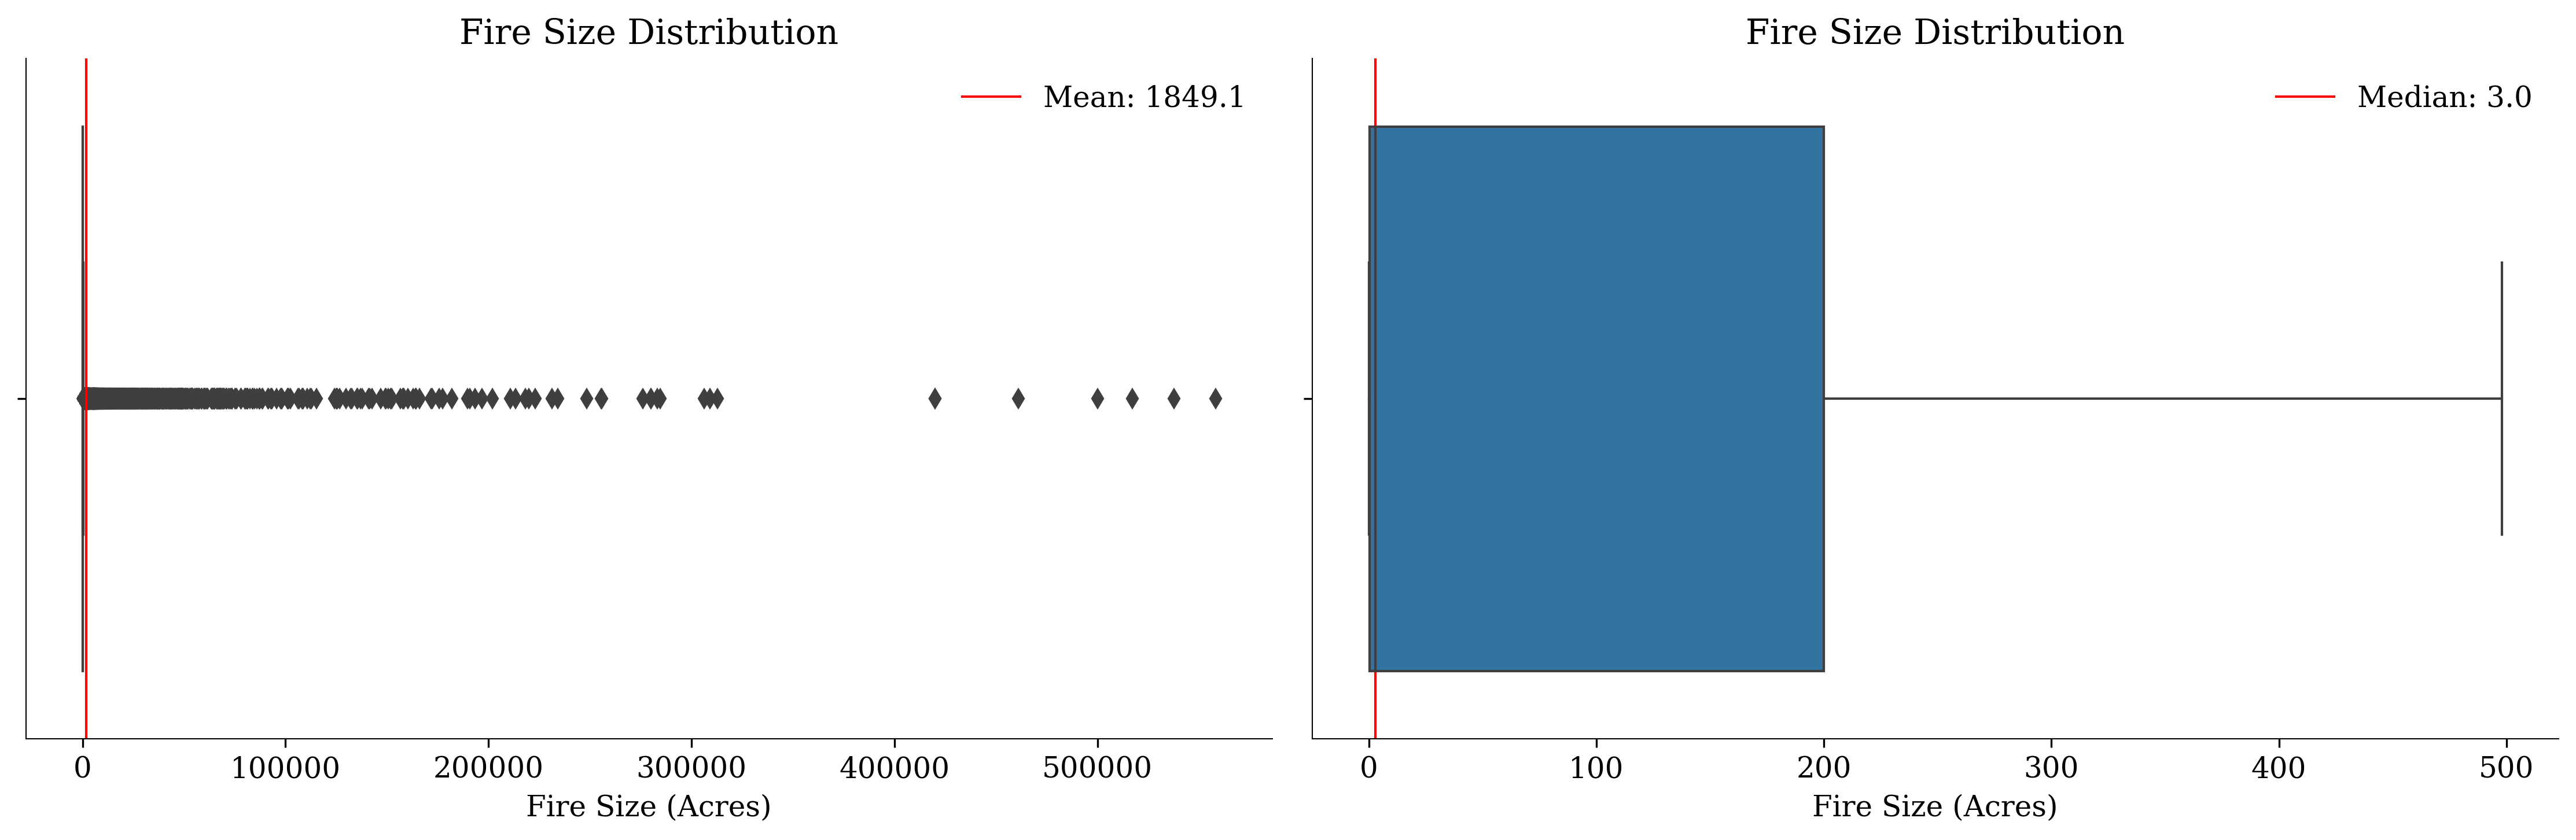

In [3]:
utils.PlotFireSizeDistribution(df)

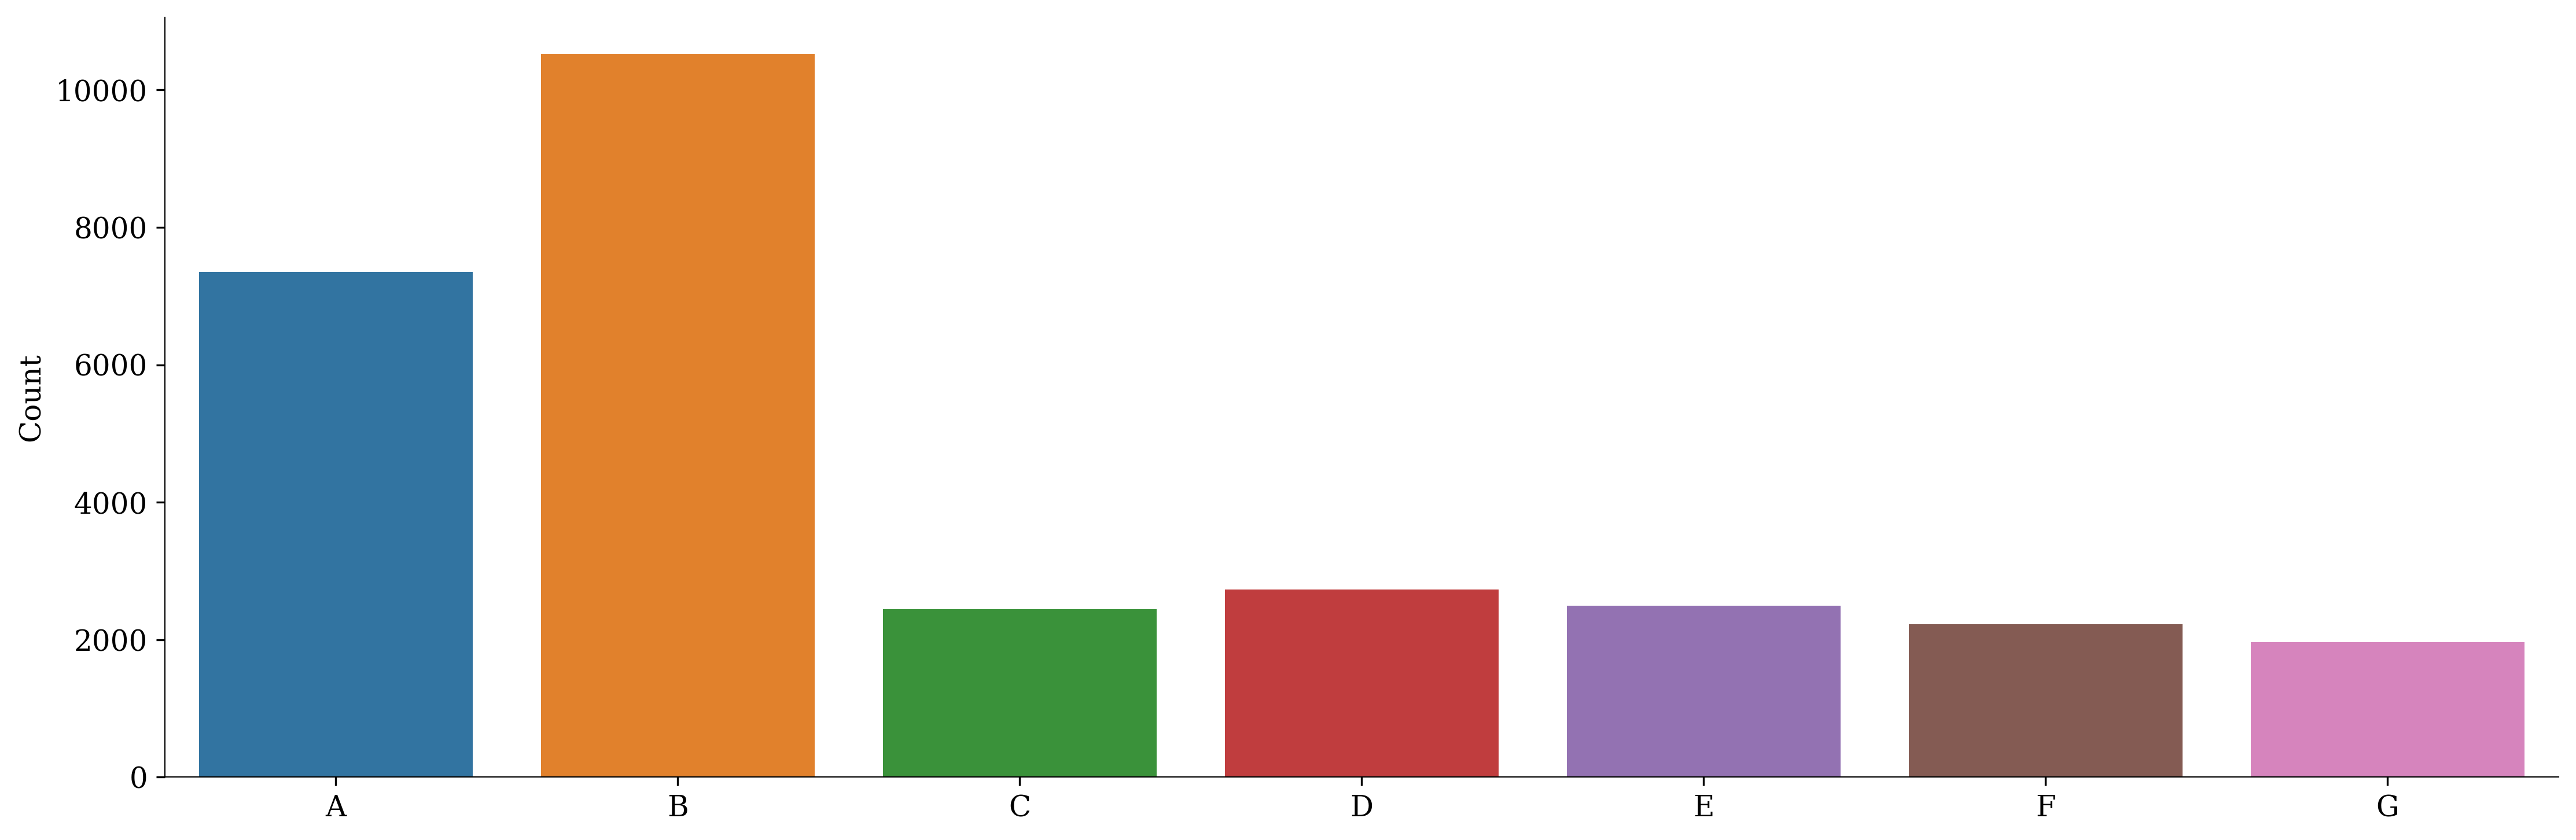

In [4]:
fire_size_df = utils.count_percentage_df(df['FIRE_SIZE_CLASS']).sort_index()

plt.figure(figsize=(15, 5))
sns.barplot(y='Count', x=fire_size_df.index, data=fire_size_df)
plt.show()

In [5]:
fig, axes = plt.subplots(4, 2, figsize=(30, 30))

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

for idx, tpl in enumerate(zip(['A', 'B', 'C', 'D', 'E', 'F', 'G'], colors)):
    fire_class, color = tpl
    tmp = df[df['FIRE_SIZE_CLASS'] == fire_class]
    plt.subplot(4, 2, idx + 1)
    plt.title(f'Fire Size Class {fire_class}')
    sns.boxplot(x=tmp['FIRE_SIZE'], color = color)
fig.delaxes(axes[3][1])
plt.show()

Given the vast distributions, we see that binning the fires into meaningful new bins is a challenging task in and of itself. Perhaps there is some other distinction that we should be able to make.

---
<a id='split'></a>
## Splitting the Data

Looking at the distributions of fire size, there is no obvious binning that we can do. Instead, what we can do is make a qualitative distinction between the fires. According to the Northwest Interagency Coordination Centre, wildfires that are greater than 100 acres in size are considered large. It is these large wildfires that pose a greater risk to the environment, health, and other factors that make it worth our time to create a model that is able to successfully distinguish between large and not large fires. 

With this size as our threshold, we can create a binary column, called `large_wildfire`, that describes whether a fire is large ($\ge$100 acres) or not

In [6]:
df['large_wildfire'] = df['FIRE_SIZE'].apply(lambda x: 1 if x >= 100 else 0)

From the box plots above we could intuit that a fire size of greater than 100 acres will create an imbalanced data set. Let us see how imbalanced the data is.

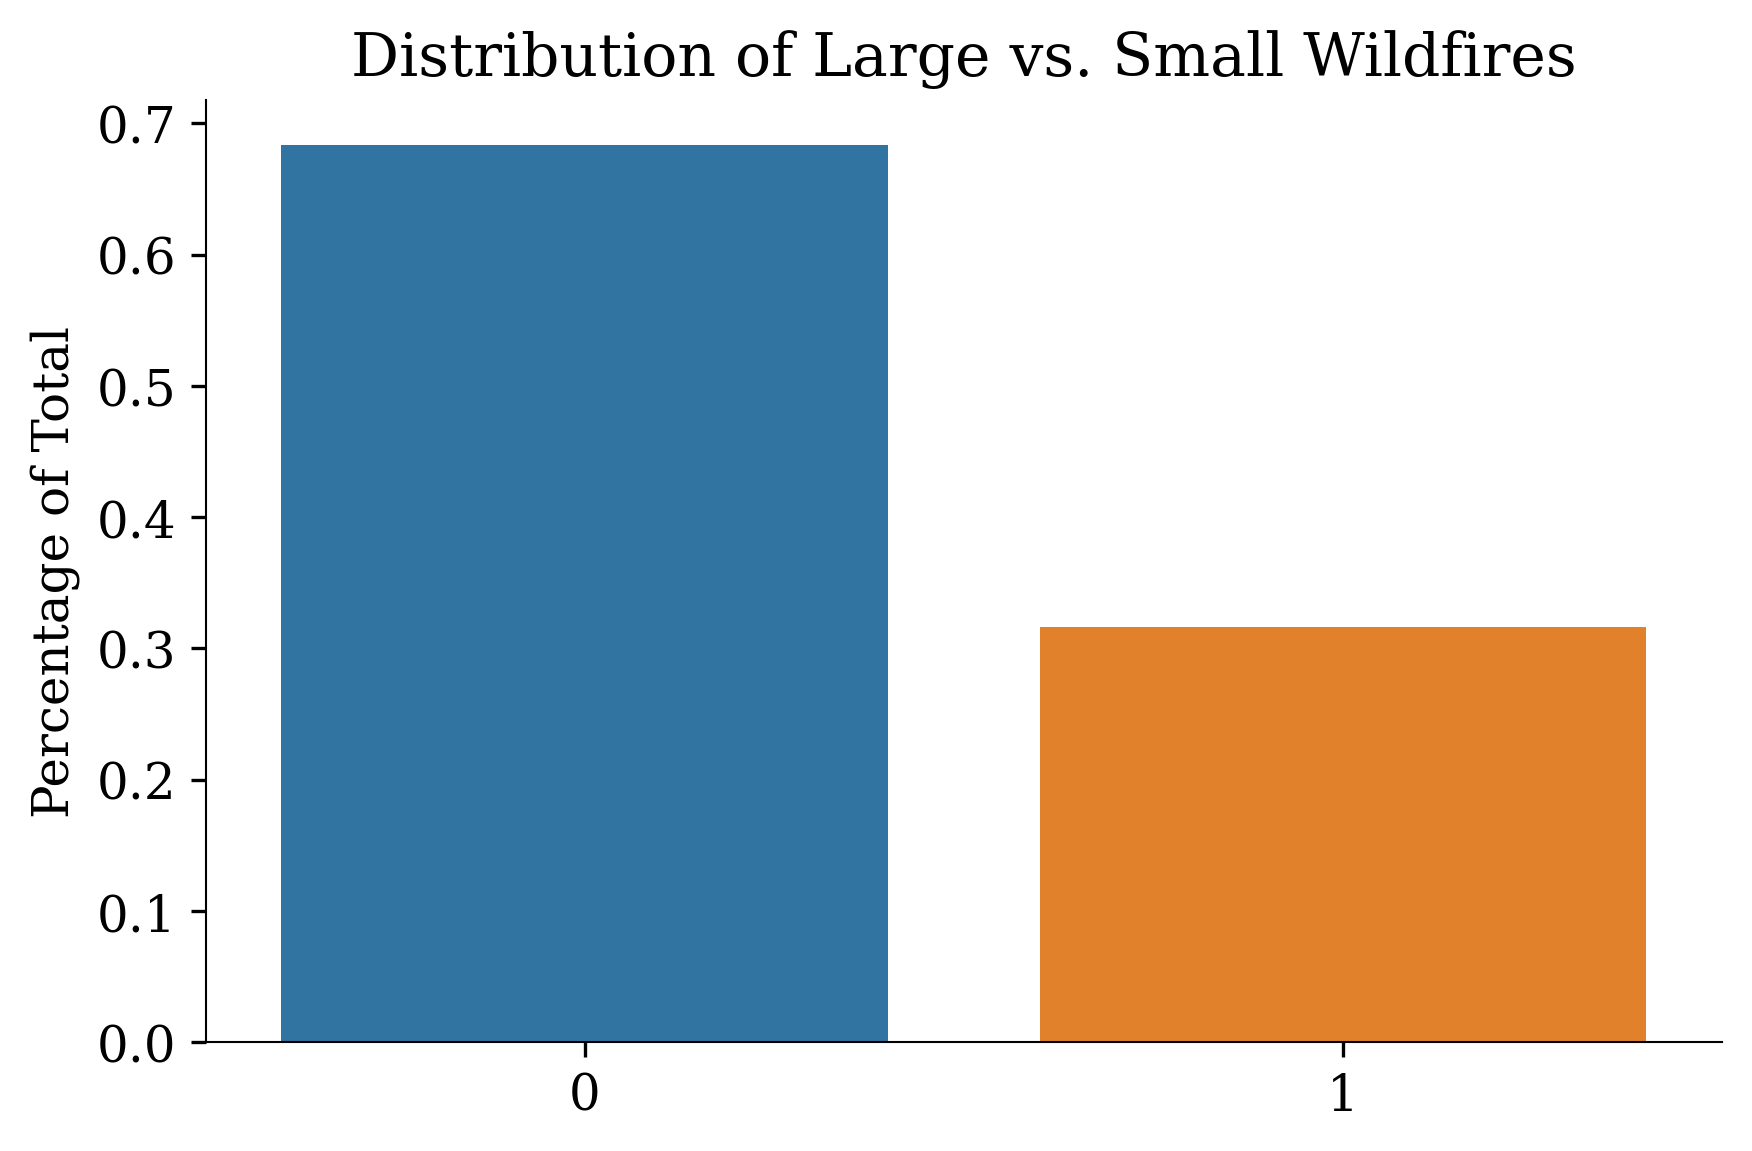

In [7]:
g = utils.count_percentage_df(df['large_wildfire'])
plt.figure()
plt.title('Distribution of Large vs. Small Wildfires')
sns.barplot(x=g.index, y='Percentage of Total', data=g)
plt.show()

Although this is still imbalanced, we have created a meaningful separation in our wildfires while simultaneously simplifying the classification problem. We can therefore attempt to build a model that is able to distinguish between these binary choices.

---
<a id='modelling'></a>
## Modelling

We will begin by building a number of logistic regression models, optimising these, followed by using an ensemble method to create the most accurate model. Before we do this however, we need to do the basic preprocessing of our variables, as we are going to be using logistic regression.

In [8]:
df_categorical_processed = utils.BasicCategoricalPreprocessing(df)
df_processed, _ = utils.BasicNumericPreprocessing(df_categorical_processed)
df_processed.shape

(29734, 86)

## Logistic Regression

In [9]:
# Create a function that can generate X and y variables
def create_x_y(df):
    X = df.drop(['FIRE_SIZE', 'FIRE_SIZE_CLASS', 'large_wildfire'], axis=1)
    y = df['large_wildfire']
    
    return X, y

In [10]:
# Create X and y
X, y = create_x_y(df_processed)

In [11]:
# Create train and test set
X_train, X_test, y_train, y_test = model_utils.CreateTransformedTTS(X, y)

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression()
logit.fit(X_train, y_train)

# Score the model
logit.score(X_test, y_test)

0.7476038338658147

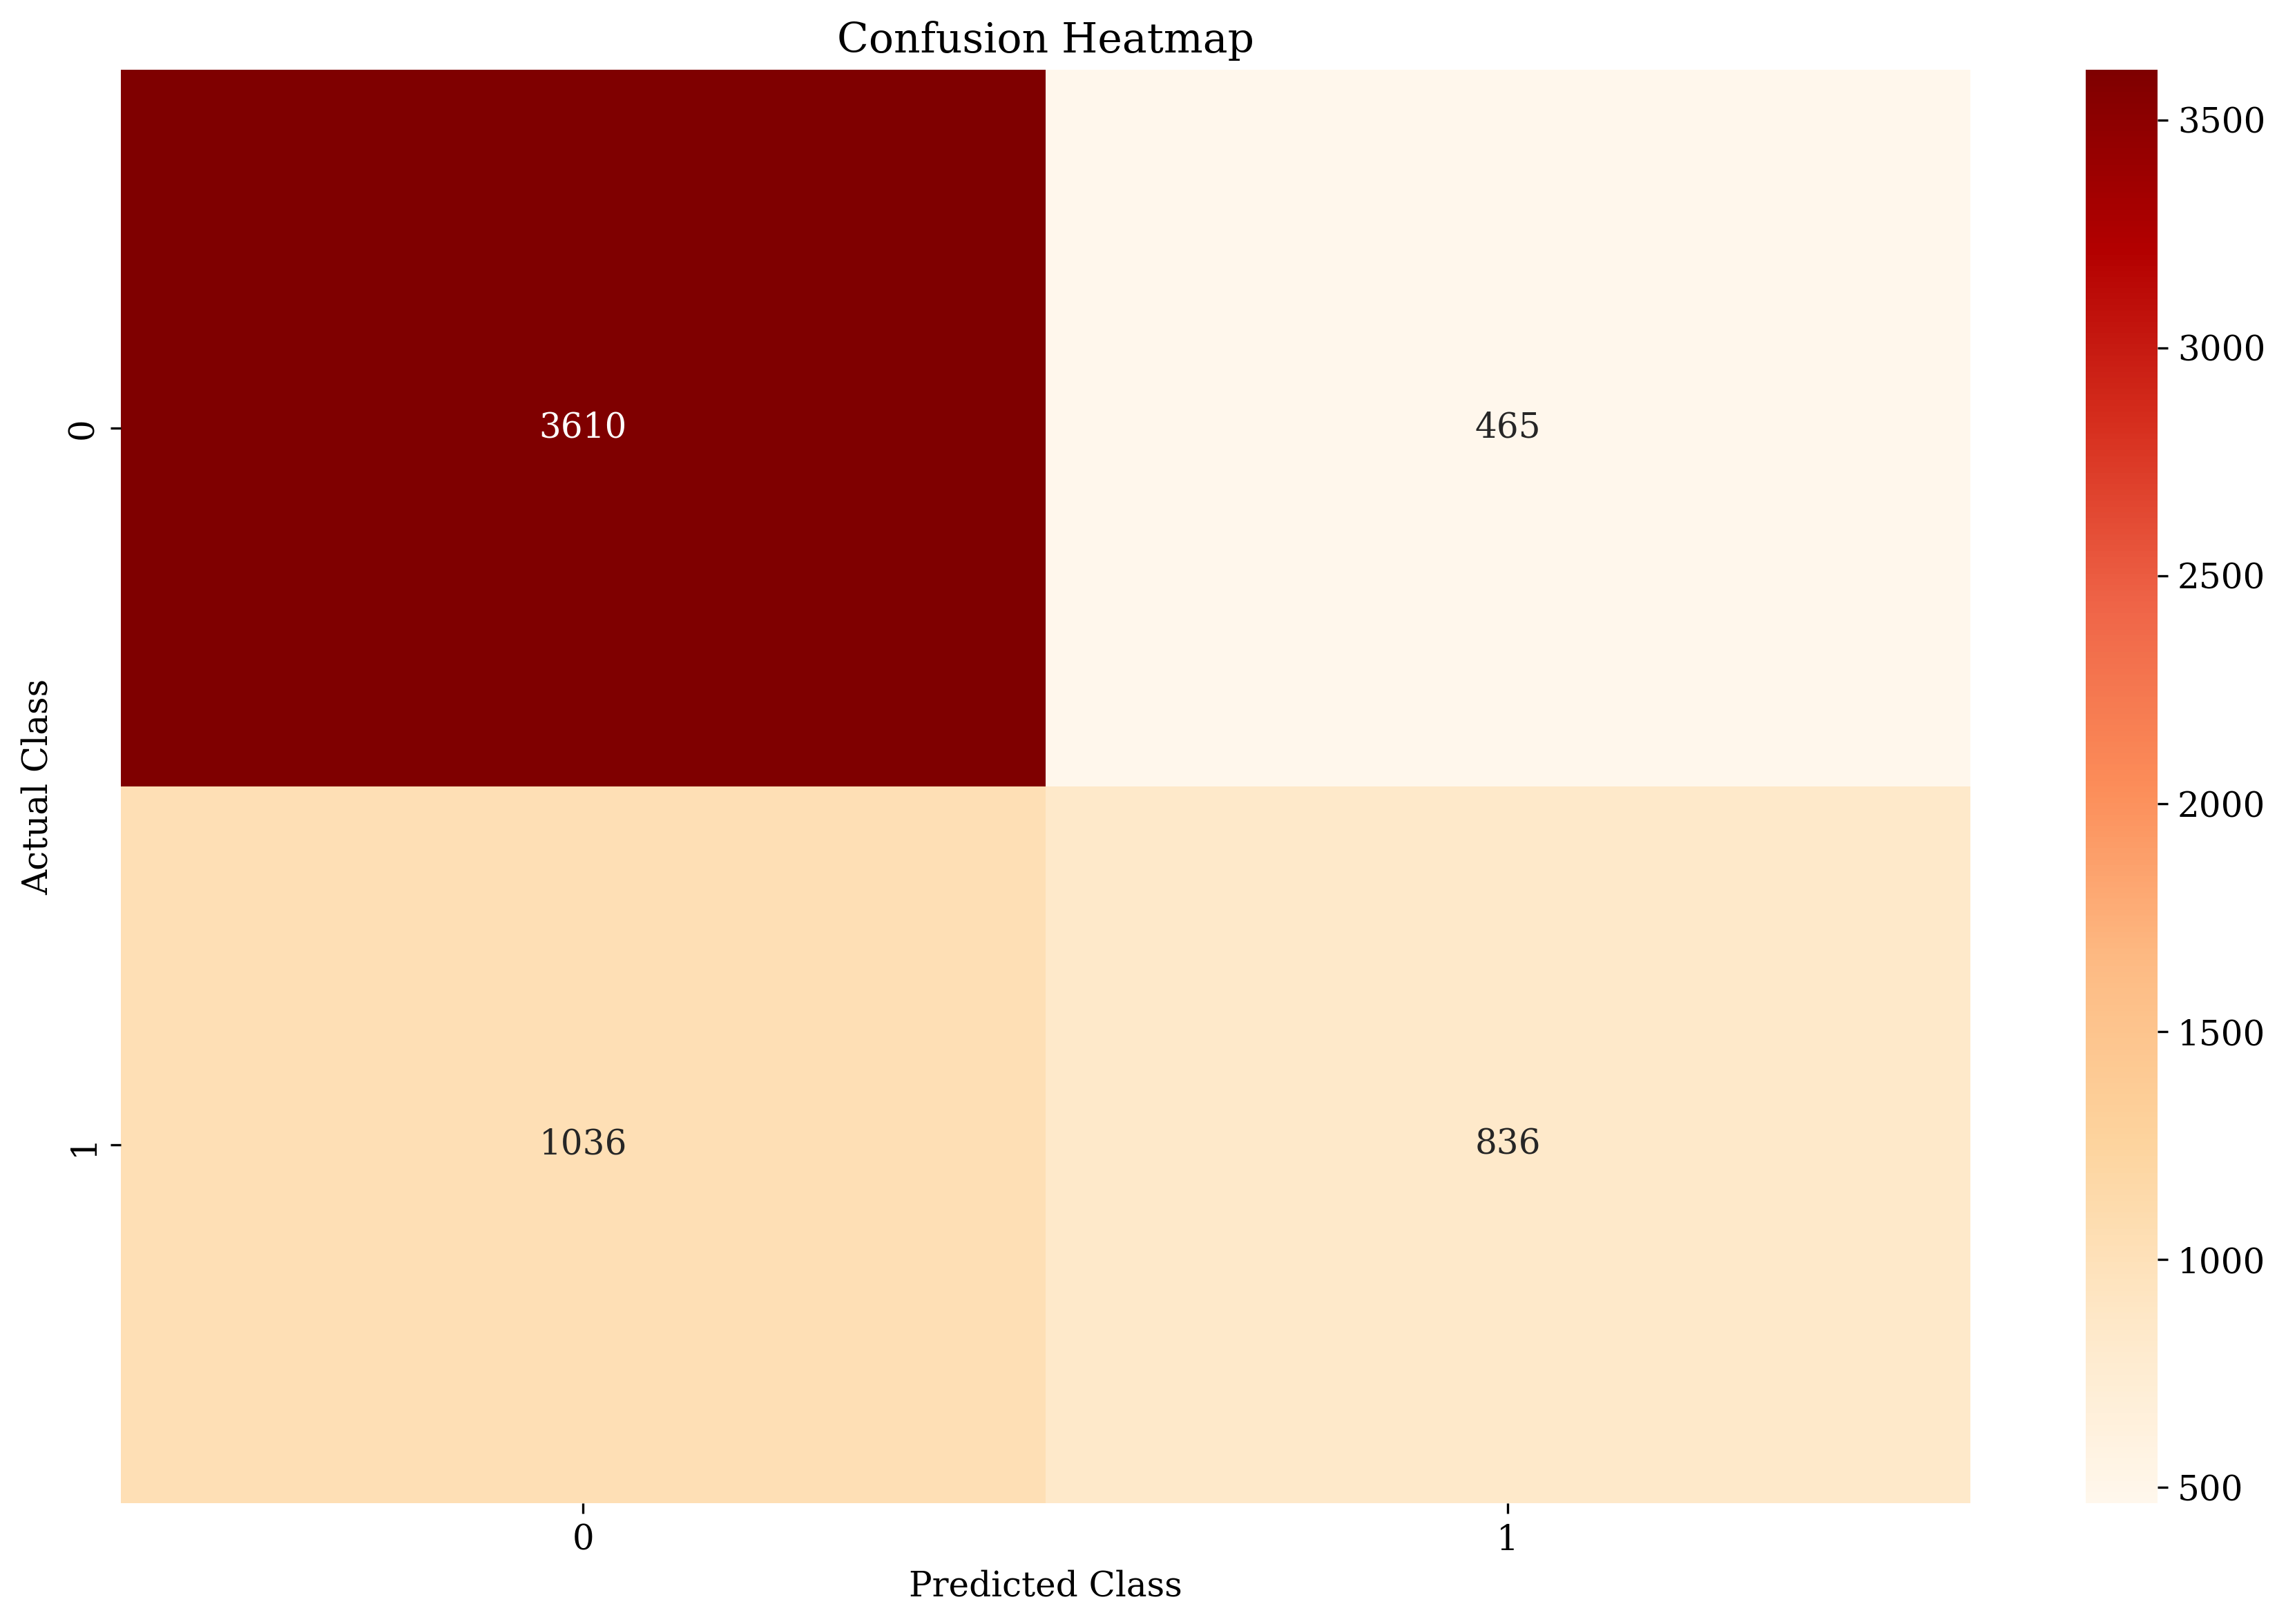

              precision    recall  f1-score   support

           0       0.78      0.89      0.83      4075
           1       0.64      0.45      0.53      1872

    accuracy                           0.75      5947
   macro avg       0.71      0.67      0.68      5947
weighted avg       0.73      0.75      0.73      5947



In [13]:
model_utils.PlotConfusionMatrix(logit, X_test, y_test)

Now that the classification task has been simplified we see that the model is able to achieve a much higher accuracy. There still is the issue that larger fires are harder to identify which is shown by the relatively low precision and recall scores for large fires. 

Let us see the coefficients for this model.

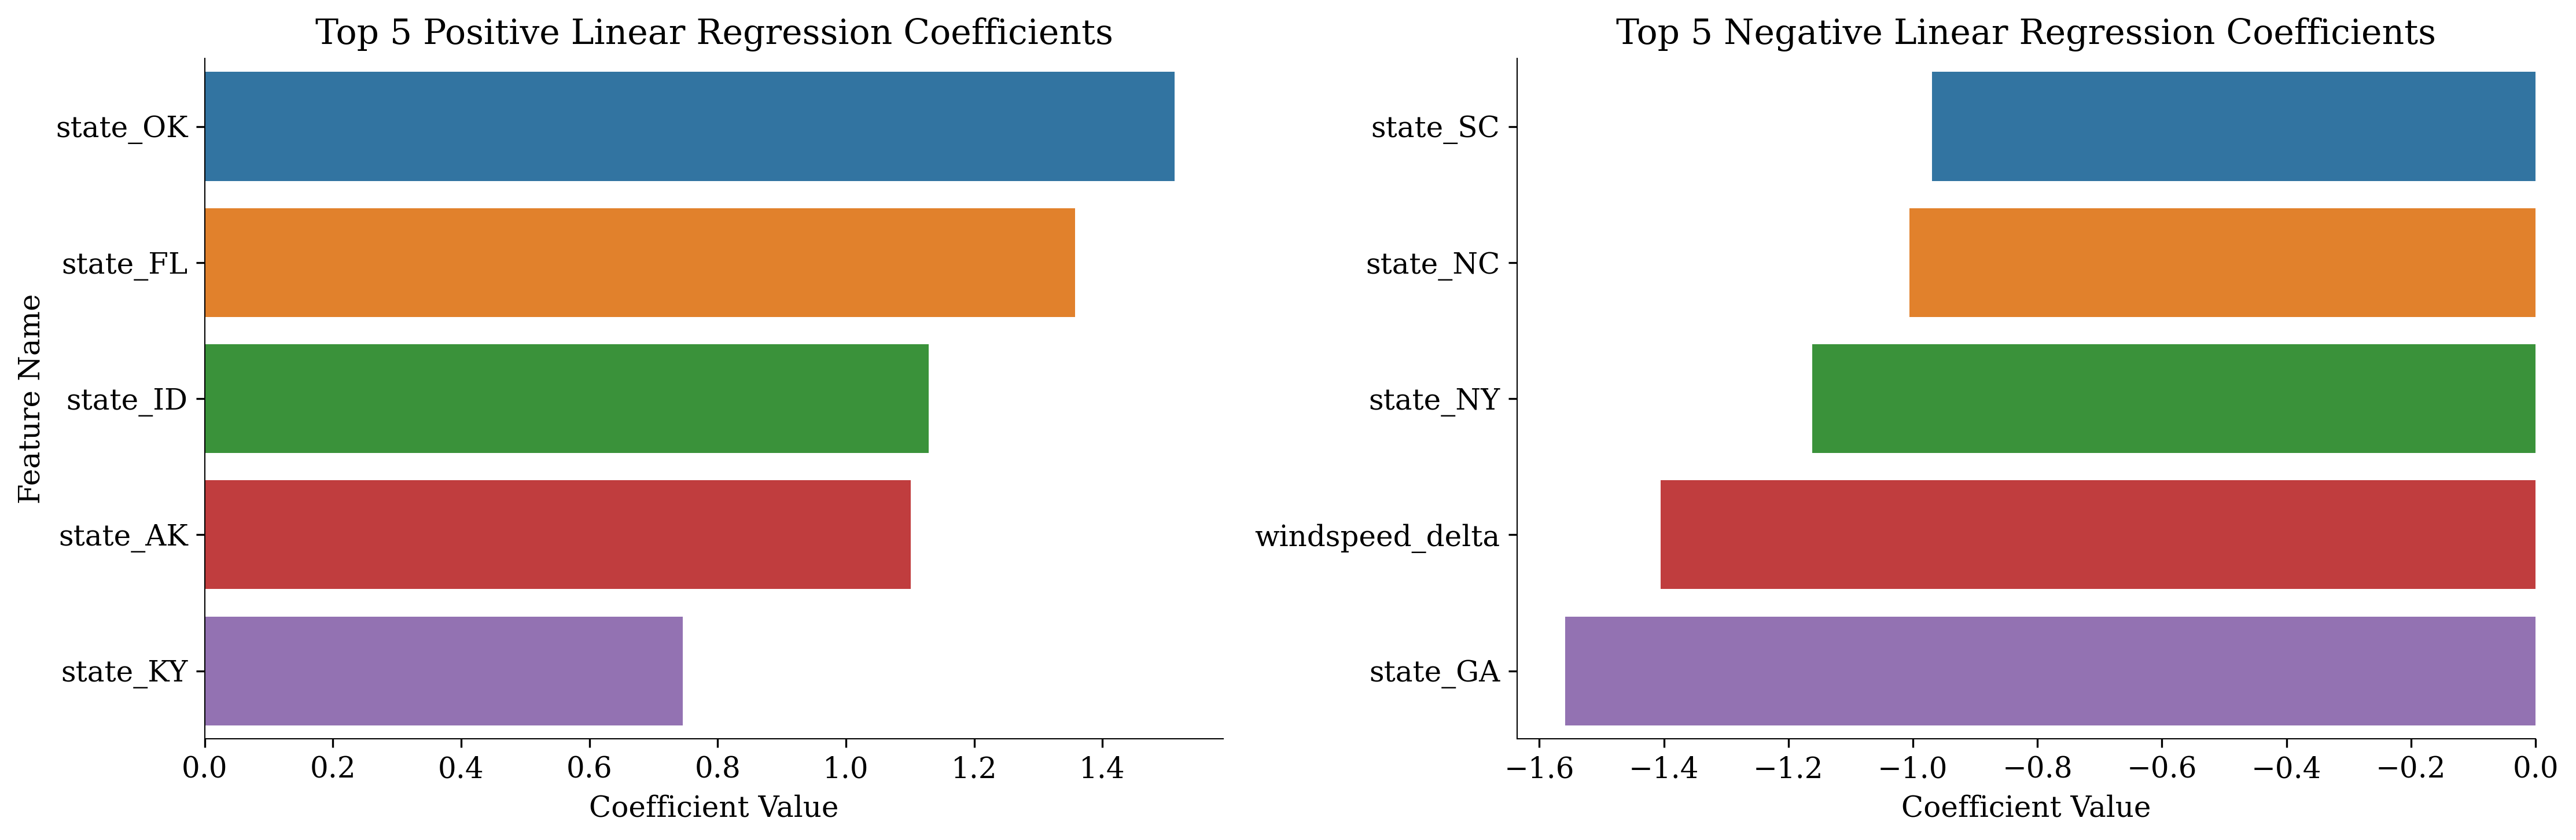

In [14]:
model_utils.PlotCoefficients(logit, X)

As in previous models, we see that the model is primarily using the state location of a fire as a heuristic for fire size. This model is therefore simply going to evaluate the probability that a fire is greater than 100 acres given the historic sizes of a fire within a given state. While such a model would be accurate, it is not going to provide particularly insightful information.

Given this outcome we will continue our model building by looking at a decision tree, which has historically considered other features as more important - an aspect of the model that means it could yield more interestng information for us.

## Decision Tree

Using a decision tree classifier we hope to not only create a more accurate model, but also identify variables other than the state that are indicative of large wildfires. As we are using a decision tree, we will be using the data in which the categorical columns have been processed, but not the numerical columns.

In [15]:
X, y = create_x_y(df_categorical_processed)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

In [18]:
from sklearn.tree import DecisionTreeClassifier

# Using the optimum values from the models created previously
dt_model = DecisionTreeClassifier(max_depth=6, min_samples_leaf=10)
dt_model.fit(X_train, y_train)

dt_model.score(X_test, y_test)

0.7467630738187321

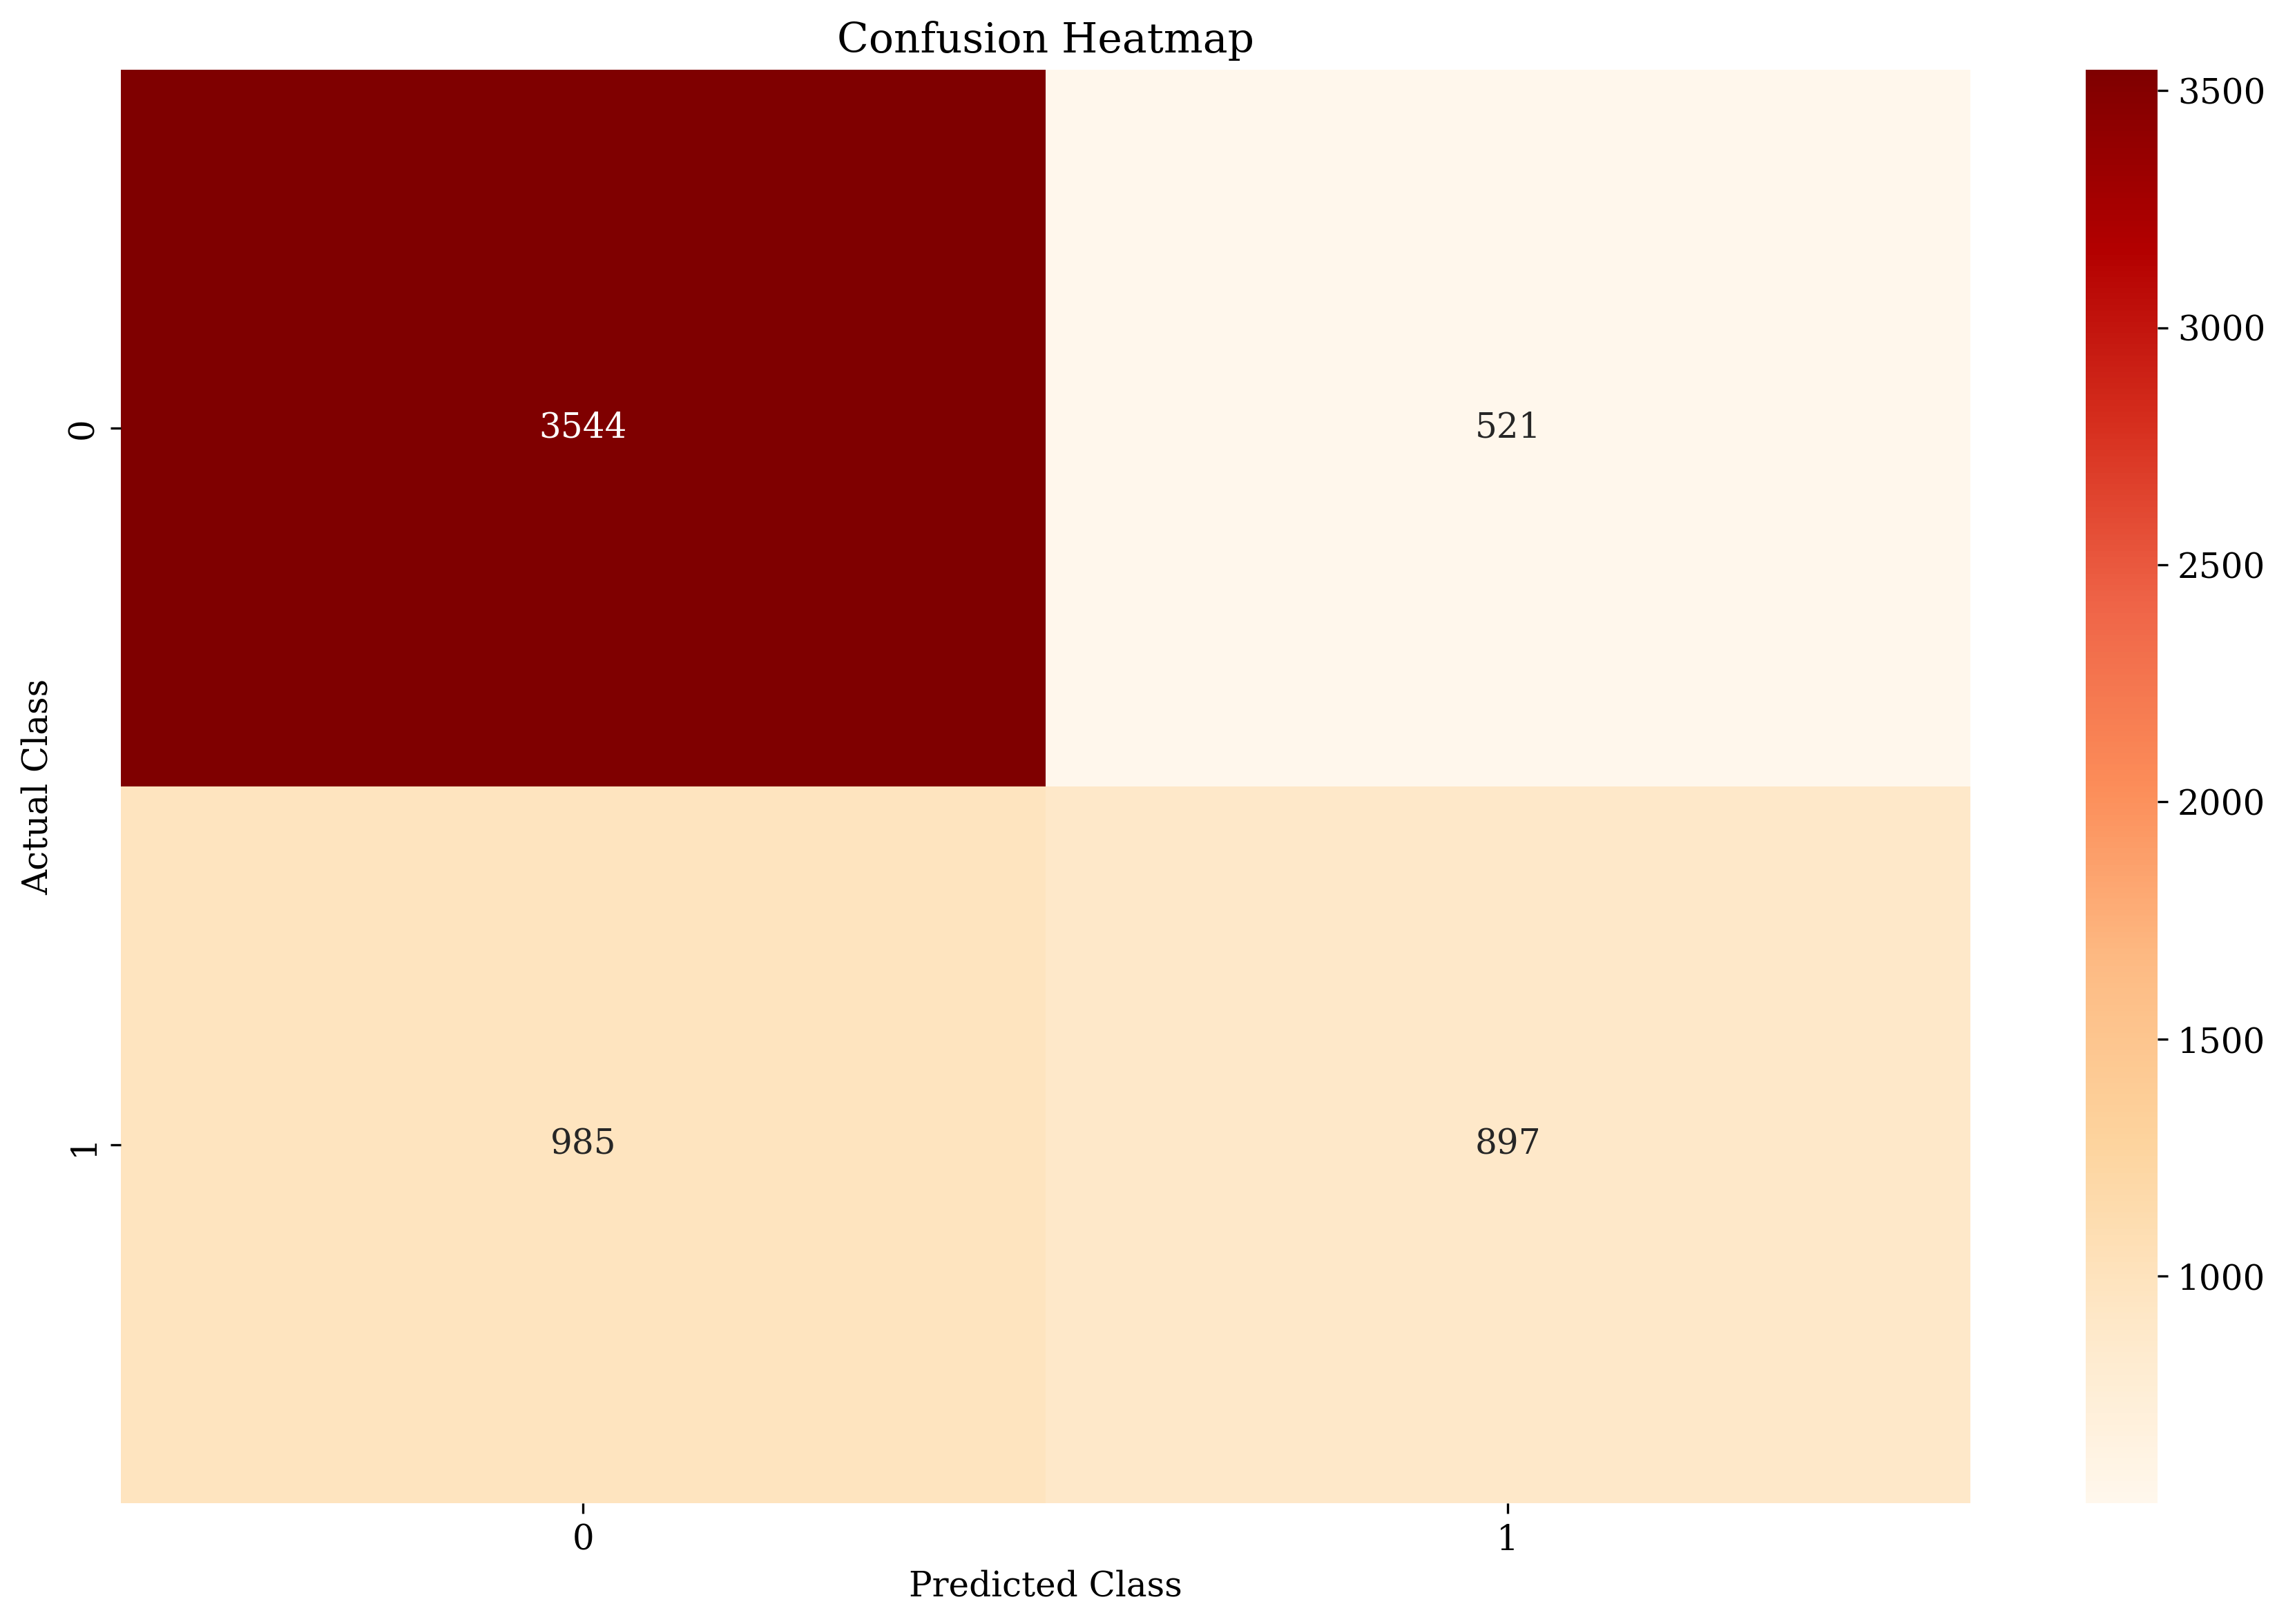

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      4065
           1       0.63      0.48      0.54      1882

    accuracy                           0.75      5947
   macro avg       0.71      0.67      0.68      5947
weighted avg       0.74      0.75      0.74      5947



In [19]:
model_utils.PlotConfusionMatrix(dt_model, X_test, y_test)

From the confusion matrix we see that the accuracy of the model is similar to that of the logistic regression. But what about the feature importances?

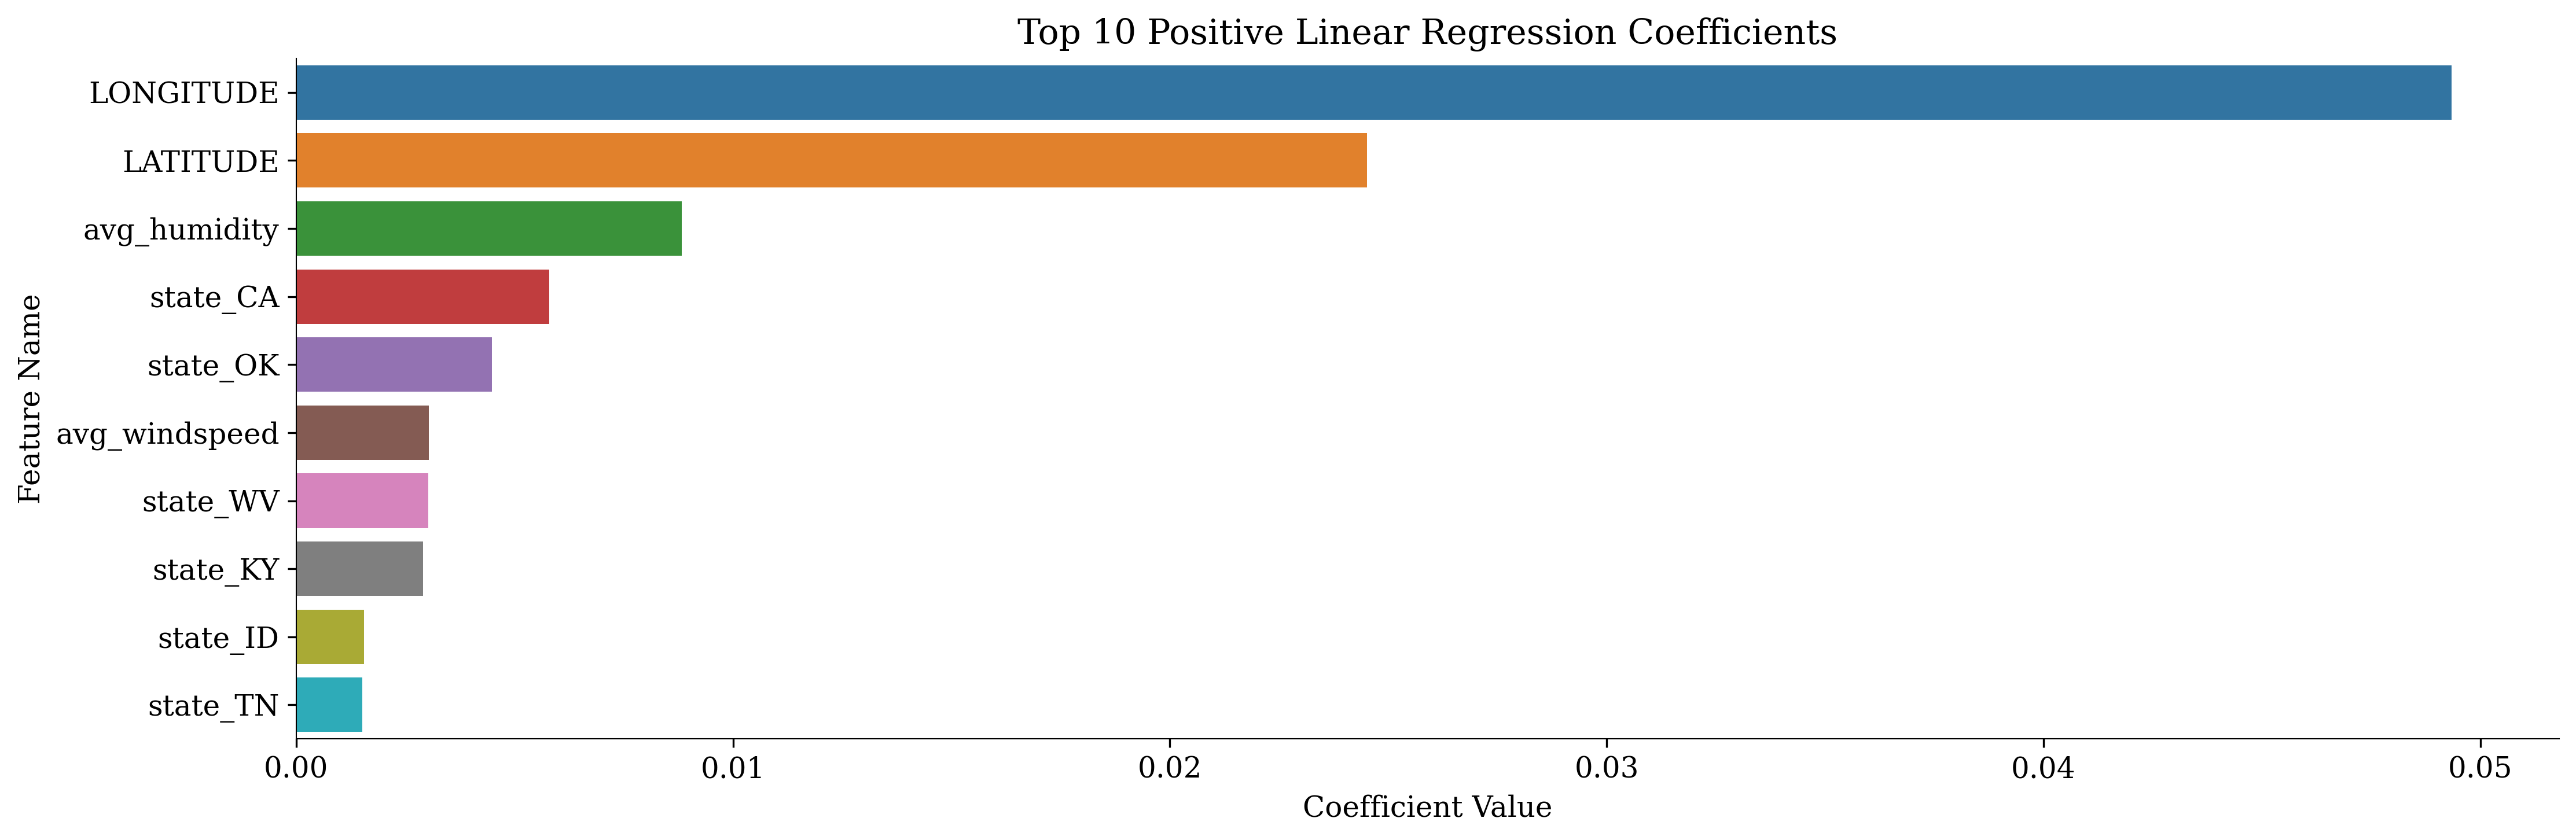

In [20]:
import dt_utils

dt_utils.plot_feature_importances(dt_model, X)

Unlike the logistic regression, we see that the most important features are the latitude and longitude, alongside the average humidity. While these features are the most important, their coefficient values are still very low, meaning that they are not that indicative of wildfire sizes.

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from tempfile import mkdtemp

cachedir = mkdtemp()

estimators = [('reduce_dim', PCA()),
              ('model', DecisionTreeClassifier())]

pipe = Pipeline(estimators, memory=cachedir)

param_grid = [{'reduce_dim': [PCA(), PCA(n_components=0.9), None], 
               'model__max_depth': [3, 4, 5, 6, 7, 8, 9],
               'model__criterion': ['gini', 'entropy'],
               'model__splitter': ['best', 'random'],
               'model__min_samples_leaf': list(range(2, 20, 2))}]

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)
dt_fittedgrid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 756 candidates, totalling 3780 fits


In [23]:
dt_fittedgrid.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 8,
 'model__min_samples_leaf': 16,
 'model__splitter': 'best',
 'reduce_dim': None}

In [24]:
dt_fittedgrid.score(X_test, y_test)

0.7546662182613082

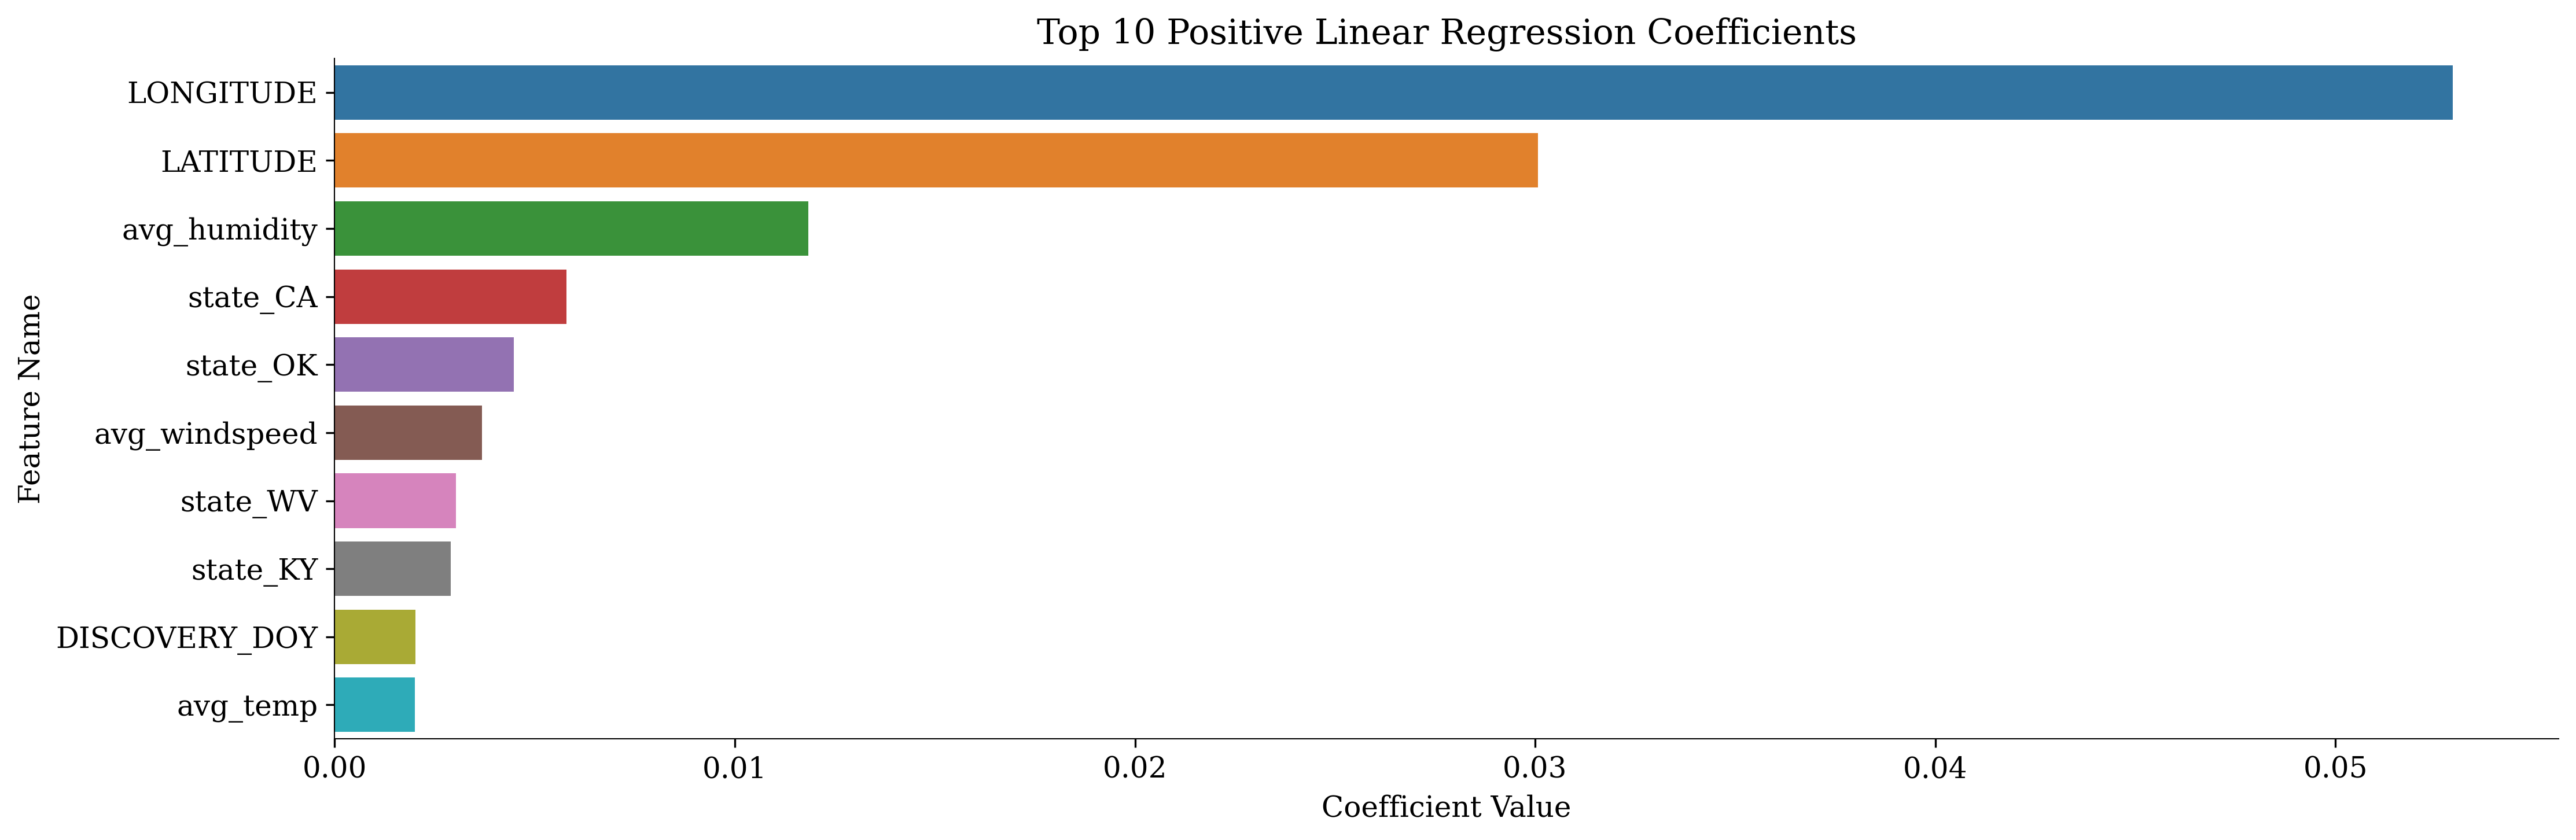

In [29]:
import dt_utils

best_model = dt_fittedgrid.best_estimator_.get_params()["model"]

dt_utils.plot_feature_importances(best_model, X)

## Ensemble method

From our previous notebook in which we looked at the various boosting methods, the method that stood out the most was XGBoost. Given the performance of XGBoost, it is perhaps the most suitable for use at this point in our project.

In [30]:
from xgboost import XGBClassifier

In [32]:
xgboost = XGBClassifier(objective='multi:softmax', num_class=2, eval_metric='mlogloss', max_depth=8)
xgboost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=8, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_class=2, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, ...)

In [33]:
xgboost.score(X_test, y_test)

0.8000672608037666

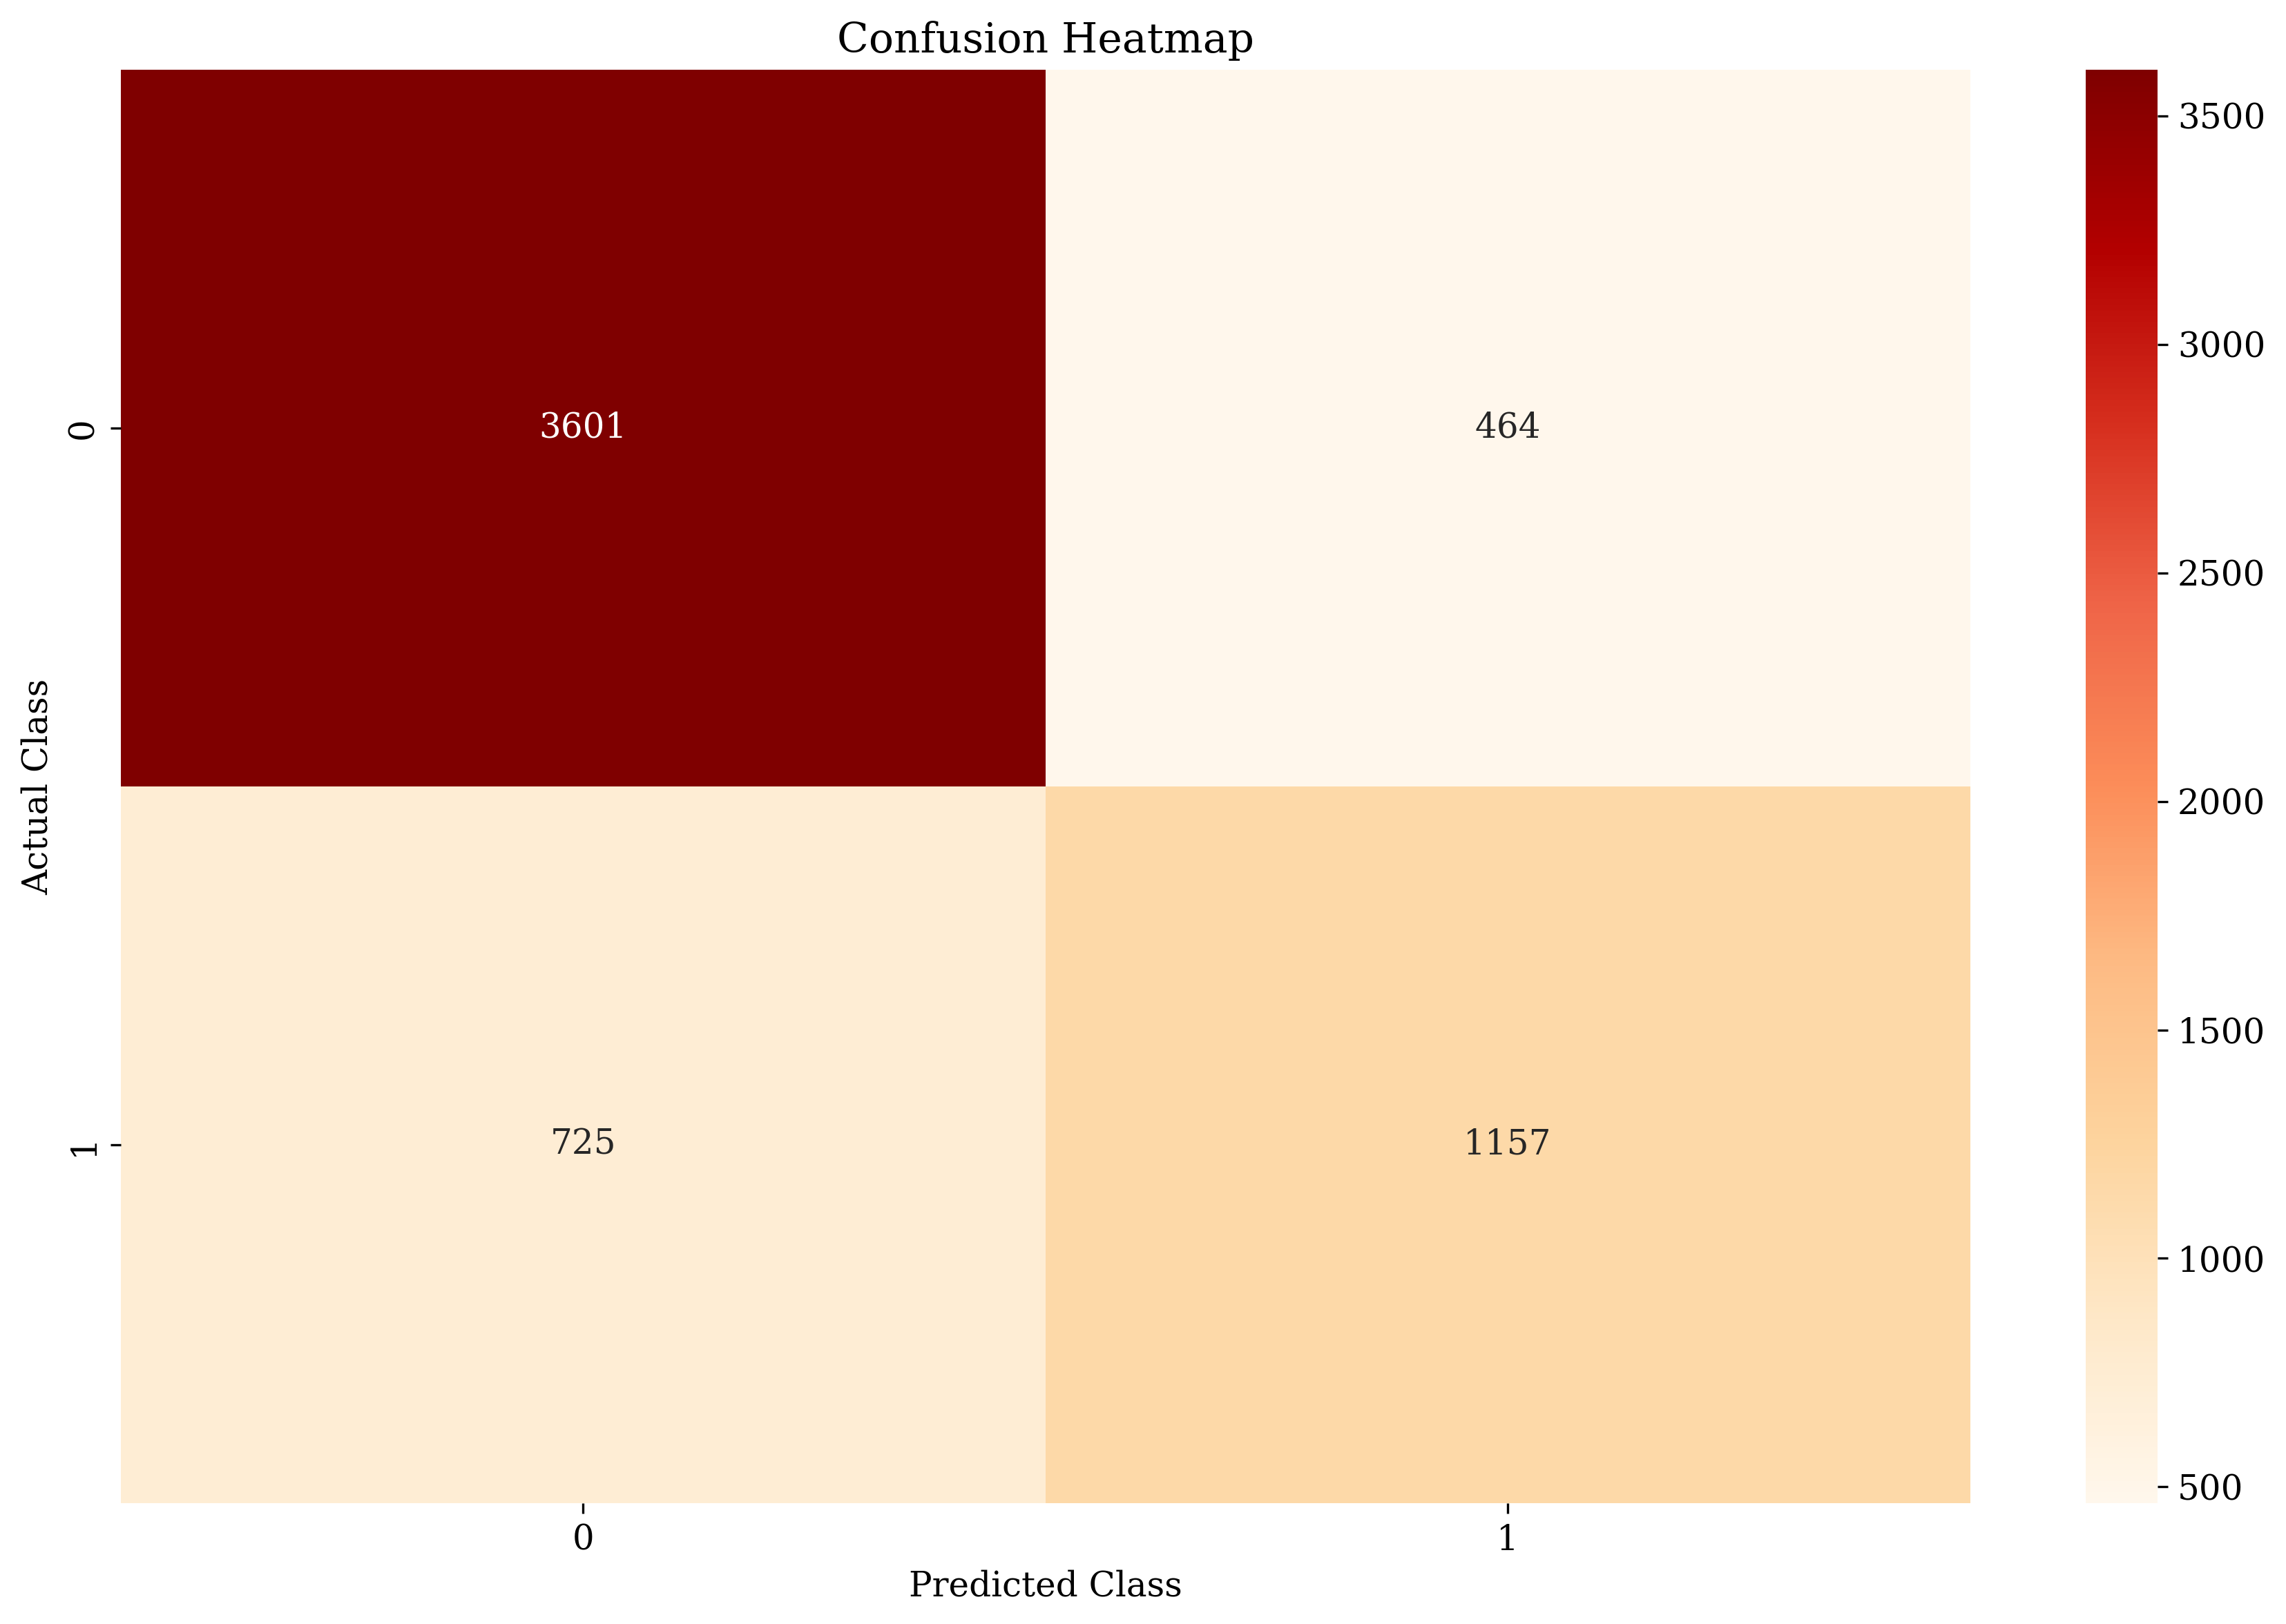

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      4065
           1       0.71      0.61      0.66      1882

    accuracy                           0.80      5947
   macro avg       0.77      0.75      0.76      5947
weighted avg       0.79      0.80      0.80      5947



In [34]:
model_utils.PlotConfusionMatrix(xgboost, X_test, y_test)

In [39]:
from sklearn.model_selection import cross_val_score

depths = list(range(1, 21))
cv_scores = []

for depth in depths:
    print(f'Fitting model {depth}/{len(depths)}', end=' \r')
    xgboost = XGBClassifier(objective='multi:softmax', num_class=2, eval_metric='mlogloss', max_depth=depth)
    cv_score = np.mean(cross_val_score(xgboost, X_train, y_train))
    cv_scores.append(cv_score)

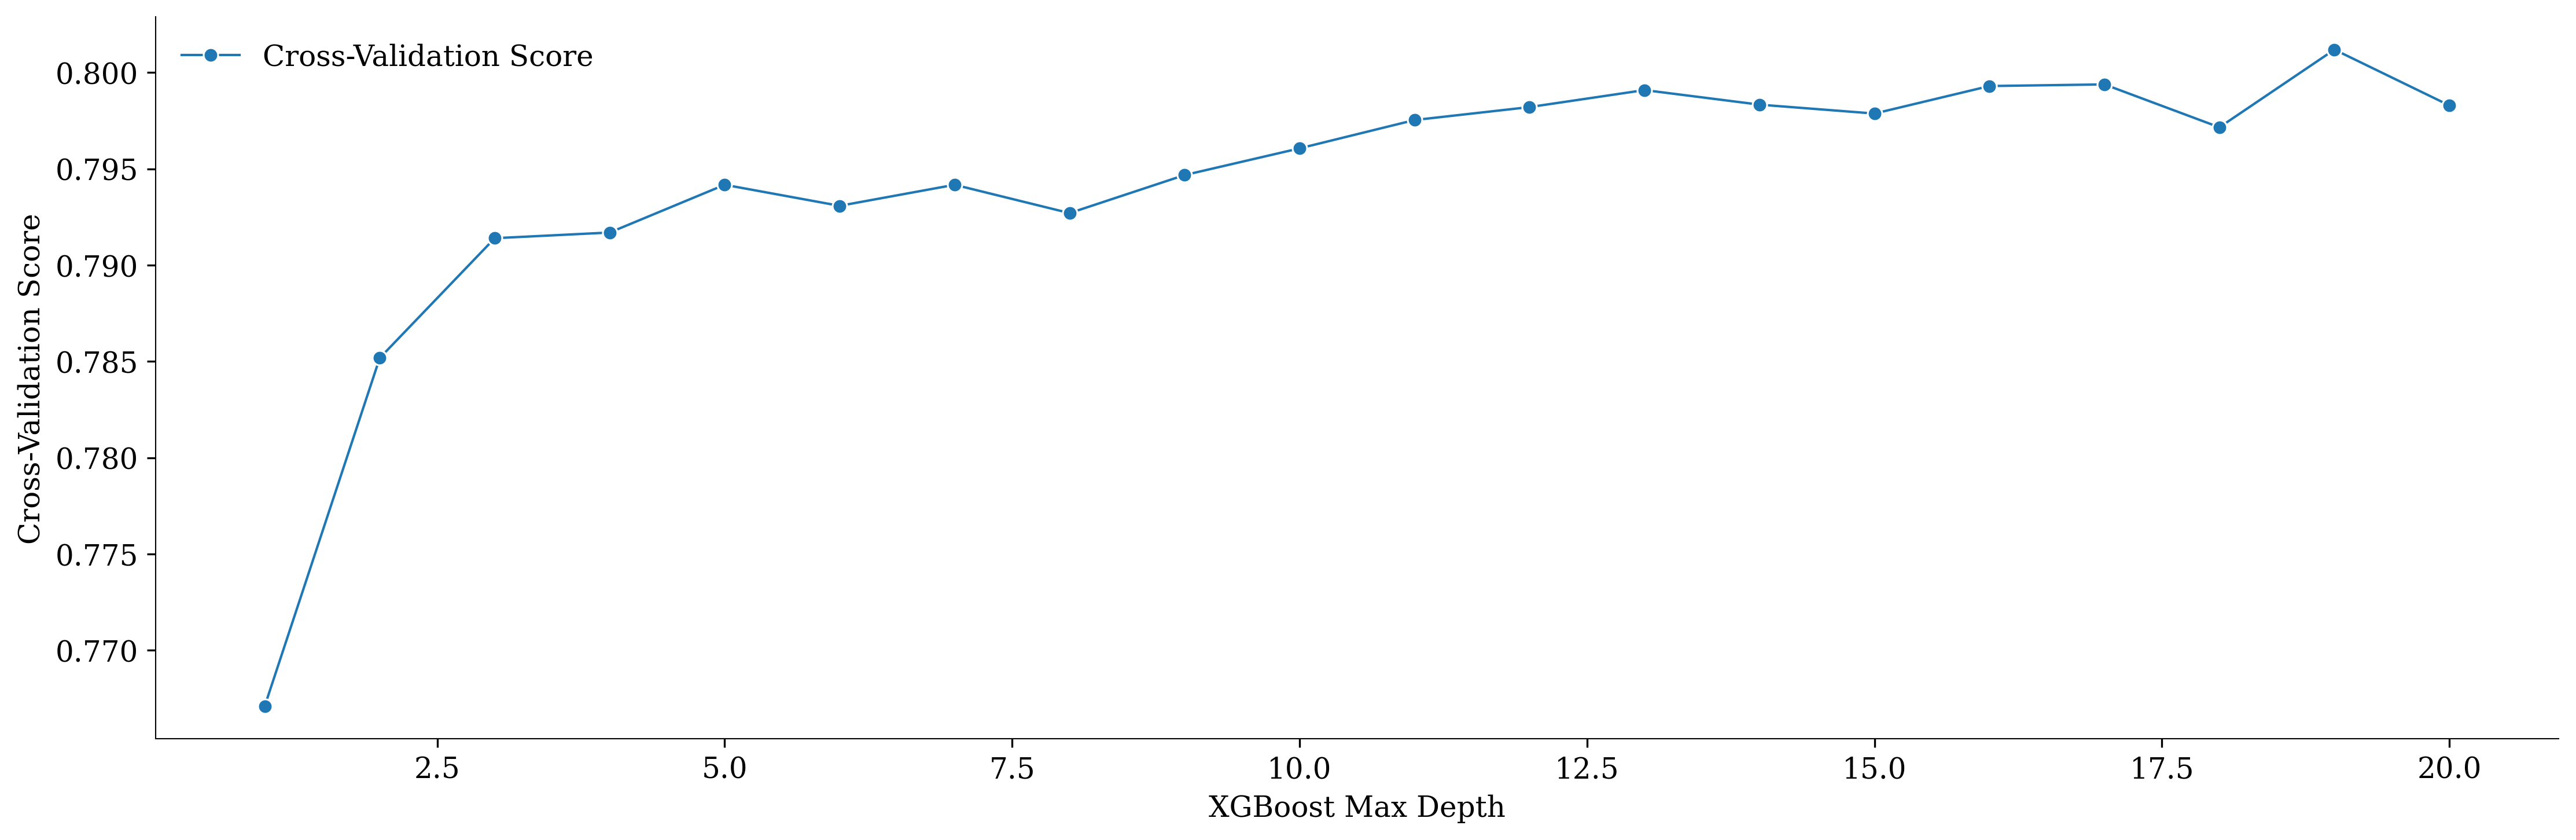

In [40]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=depths, y=cv_scores, marker='o', label='Cross-Validation Score')
plt.xlabel('XGBoost Max Depth')
plt.ylabel('Cross-Validation Score')
plt.legend()
plt.show()